### 4.10 Predicting House Prices on Kaggle

#### 4.10.1 Downloading and Caching Datasets

Here we are going to implement several utility functions to facilitate data downloading. First, we maintain a dictionary `DATA_HUB` that maps a string name to a URL with the SHA-1 of the file at the URL, where SHA-1 verifies the integrity of the file. Such datasets are hosted on the `DATA_URL` site.

In [1]:
import d2l
import os
from mxnet import gluon
import zipfile
import tarfile

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir = '../data'):
    assert name in DATA_HUB, "%s doesn't exist" % name
    url, sha1 = DATA_HUB[name]
    d2l.mkdir_if_not_exist(cache_dir)
    return gluon.utils.download(url, cache_dir, sha1_hash=sha1)

In [4]:
def download_extract(name, folder = None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == '.tar' or ext == '.gz':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted'
    fp.extractall(base_dir)
    if folder:
        return base_dir + '/' + folder + '/'
    else:
        return data_dir + '/'
    
def download_all():
    for name in DATA_HUB:
        download(name)

#### 4.10.3 Accessing and Reading the Dataset

In [5]:
%matplotlib inline
import d2l
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd

npx.set_np()

In [6]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv',
                                'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let's take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first four examples:

In [9]:
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, the first feature is the `ID`. This helps the model identify each training example. While this is convenient, it does not carry any information for prediction purposes. Hence, we remove it from the dataset before feeding the data into the network.

In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#### 4.10.4 Data Preprocessing

As stated above, we have a wide variety of data types. Before we feed it into a deep network, we need to perform some amount of processing. Let's start with the numerical features. We begin by **replacing missing values with the mean**. This is a reasonable strategy if features are missing at random. To adjust them to a common scale, we rescale them to zero mean and unit variance. This is accomplished as follows:
- $x \leftarrow\frac{x - \mu}{\sigma}$

To check that this transforms $x$ to data with zero mean and unit variance simply calculate $E[\frac{(x-\mu)}{\sigma}] = \frac{(\mu - \mu)}{\sigma} = 0$. To check the variance we use $E[(x - \mu)^2] = \sigma^2$ and thus the transformed variable has unit variance. The reason for normalizing the data is that it brings all features to the same order of magnitude. After all, we do not know a priori which features are likely to be relevant. 

In [11]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing 
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Next we deal with discrete values. This includes variables such as `MSZoning`. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of 0 and 1. For instance, `MSZoning` assumes the values 'RL' and 'RM'. They map into vectors (1,0) and (0,1) respectively. Pandas does this automatically for us

In [12]:
# Dummy_na=True refers to a missing value being a legal EIGENVALUE, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na = True)
all_features.shape

(2919, 331)

You can see that this conversion increases the number of features from 79 to 331. Finally, via the values attribute, we can extract the NumPy format from the Pandas dataframe and convert it into MXNet's native ndarray representation for training.

In [13]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype = np.float32)
test_features = np.array(all_features[n_train:].values, dtype = np.float32)
train_labels = np.array(train_data.SalePrice.values,
                       dtype = np.float32).reshape(-1, 1)

#### 4.10.5 Training
To get started we train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition winning submission but it provides a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data preprocessing bug. And if things work, the linear model will serve as a baseline3 giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

In [67]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dropout(0.2),
            nn.Dense(1))
    net.initialize()
    return net

With house prices, as with stock prices, we care about RELATIVE QUANTITIES more than absolute quantities. More concretely, we tend to care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error $y - \hat{y}$. For instance, if our prediction is off by USD 100,000 when estimating the price of a house in Rural Ohio, where the value of a typical house is 125,000 USD, then we are probably doing a horrible job. On the other hand, if we err by this amount in Los Altos Hills, California, this might represent a stunningly accurate prediction (there, the median house price exceeds 4 million USD).

One way to address this problem is to measure the discrepancy in the **logarithm of the price estimates**. In fact, this is also the official error metric used by the competition to measure the quality of submissions. After all, a small value $\delta$ of $log_y - log_\hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

- $L = \sqrt{\frac{1}{n}\sum(log_{y_i} - log_{\hat{y}_i})^2}$

In [68]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the 
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

Unlike in previous sections, our training functions here will rely on the Adam optimizer (a slight variant on SGD that we will describe in greater detail later). The main appeal of Adam vs vanilla SGD is that the Adam optimizer, despite doing no better (and sometimes worse) given unlimited resources for hyperparameter optimization, **people tend to find that it is significantly less sensitive to the initial learning rate**.

In [69]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size) # !!! So that's why earlier X.shape[0] was utilized!!!!!!!!
            # Take a step (update the params) after EACH batch!
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### 4.10.6 *k*-Fold Cross-Validation

Using the k-Fold CV we are going to select the model design and to adjust the hyperparameters. We first need a function that returns $i^{th}$ fold of the data in a k-fold CV procedure. It proceeds by slicing out the $i^{th}$ segment as validation data and returning the rest as training data. Note that this is not the most efficient way of handling data and we would definitely do something much smarter if our dataset was considerably larger. But this added complexity might obfuscate our code unnecessarily so we can safely omit here owing to the simplicity of our problem.

In [70]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

In [71]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

#### 4.10.7 Model Selection

In this example, we pick an un-tuned set of hyperparameters and leave it up to the reader to improve the model. Finding a good choice can take quite some time, depending on how many things one wants to optimize over. Within reason, the k-fold cross-validation is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

fold 0, train rmse: 0.132603, valid rmse: 0.156319
fold 1, train rmse: 0.110513, valid rmse: 0.189047
fold 2, train rmse: 0.191711, valid rmse: 0.254956
fold 3, train rmse: 0.136034, valid rmse: 0.205231
fold 4, train rmse: 0.311194, valid rmse: 0.319274
5-fold validation: avg train rmse: 0.176411, avg valid rmse: 0.224965


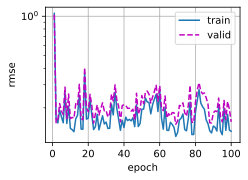

In [72]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

#### 4.10.8 Predict and Submit

In [42]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train rmse 0.162427


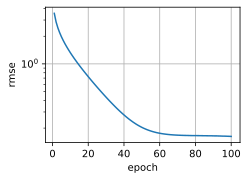

In [35]:
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)